# Installs & Imports

In [1]:
!pip install -q xgboost lightgbm dask[dataframe] pmdarima optuna wrapdisc

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 4.7 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
import lightgbm as lgb
import pmdarima as pm
import optuna
import scipy.optimize
from wrapdisc import Objective
from wrapdisc.var import QrandintVar, UniformVar, ChoiceVar
from tqdm import tqdm

# Data Loading

In [3]:
# Load the airline passengers dataset
flights = sns.load_dataset('flights')

# Create a datetime column from 'year' and 'month'
flights['date'] = pd.to_datetime(
    flights['year'].astype(str) + '-' +
    flights['month'].astype(str) + '-01'
)
flights = flights.sort_values('date').set_index('date')
flights.rename(columns={'passengers': 'value'}, inplace=True)
print("Data sample:")
display(flights.head())
print(f"\nData shape: {flights.shape}")

Data sample:


,year,month,value
date,,,
1949-01-01,1949,Jan,112
1949-02-01,1949,Feb,118
1949-03-01,1949,Mar,132
1949-04-01,1949,Apr,129
1949-05-01,1949,May,121



Data shape: (144, 3)


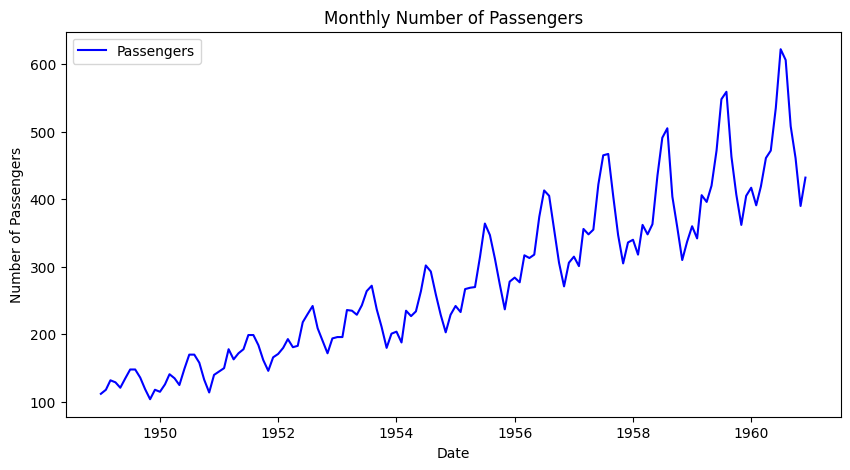

In [4]:
# Plot the data
plt.figure(figsize=(10,5))
plt.plot(flights.index, flights['value'], label='Passengers', color='blue')
plt.title("Monthly Number of Passengers")
plt.xlabel("Date")
plt.ylabel("Number of Passengers")
plt.legend()
plt.show()

# Data Preparation

## Data Transformation

In [5]:
def guerrero_lambda(series, season_length=12, lower=-2, upper=2, num_candidates=100):
    """Compute the optimal Box–Cox lambda using Guerrero's method."""
    candidate_lambdas = np.linspace(lower, upper, num_candidates)
    best_lambda = None
    best_cv = np.inf

    # Shift the series if there are non-positive values
    shift = 0
    if (series <= 0).any():
        shift = abs(series.min()) + 1
    series_shifted = series + shift

    for lam in candidate_lambdas:
        # Apply the Box–Cox transformation
        if lam == 0:
            transformed = np.log(series_shifted)
        else:
            transformed = (np.power(series_shifted, lam) - 1) / lam

        # Group the transformed values by season (e.g. for monthly data, each month is one group)
        groups = [transformed[i::season_length] for i in range(season_length)]

        # Compute the standard deviation for each season (only if group length > 1)
        sds = np.array([np.std(g, ddof=1) for g in groups if len(g) > 1])
        if np.mean(sds) == 0:
            continue

        # Compute the coefficient of variation (CV) of the seasonal standard deviations
        cv = np.std(sds, ddof=1) / np.mean(sds)

        # Select the lambda that minimizes the CV
        if cv < best_cv:
            best_cv = cv
            best_lambda = lam
    return best_lambda, shift

In [6]:
# Compute optimal lambda using Guerrero's method for monthly data (season_length=12)
optimal_lambda, shift_val = guerrero_lambda(flights['value'], season_length=12, num_candidates=1000)
print(f"Optimal Guerrero lambda: {optimal_lambda:.4f}, Shift applied: {shift_val}")

Optimal Guerrero lambda: -0.2703, Shift applied: 0


In [7]:
def boxcox_transform(series, lam, shift=0):
    """Apply Box–Cox transformation with given lambda and shift."""
    series_shifted = series + shift
    if lam == 0:
        return np.log(series_shifted)
    else:
        return (np.power(series_shifted, lam) - 1) / lam

In [8]:
def inv_boxcox_transform(transformed, lam, shift=0):
    """Apply the inverse Box–Cox transformation."""
    if lam == 0:
        return np.exp(transformed) - shift
    else:
        return np.power(transformed * lam + 1, 1/lam) - shift

In [9]:
# Apply the Guerrero-based Box–Cox transformation to the target variable
flights['value_transformed'] = boxcox_transform(flights['value'], optimal_lambda, shift_val)

In [10]:
# Check transformed values
transformation_check = flights['value_transformed']
print("Transformation Check:")
display(transformation_check.head())

Transformation Check:


,value_transformed
date,
1949-01-01,2.666384
1949-02-01,2.680861
1949-03-01,2.711279
1949-04-01,2.705117
1949-05-01,2.687752


In [11]:
# Check inverse transformation values
inverse_transformation_check = inv_boxcox_transform(flights['value_transformed'], optimal_lambda, shift_val)
inverse_transformation_check.rename('value_inverse_transformed', inplace=True)
print("Inverse Transformation Check:")
display(inverse_transformation_check.head())

Inverse Transformation Check:


,value_inverse_transformed
date,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


In [12]:
# Assert inverse_transformation_check == flights['value']
assert np.allclose(inverse_transformation_check, flights['value'], atol=1e-6)
print("Inverse transformation check passed!")

Inverse transformation check passed!


## Feature Engineering

In [13]:
def add_fourier_features(df, period=12, order=3):
    """
    Adds Fourier features (sine and cosine terms) to capture seasonality.
    For monthly data, period=12 is appropriate.
    """
    df = df.copy()
    t = np.arange(len(df))
    for k in range(1, order + 1):
        df[f'sin_{k}'] = np.sin(2 * np.pi * k * t / period)
        df[f'cos_{k}'] = np.cos(2 * np.pi * k * t / period)
    return df

In [14]:
def create_lagged_features(df, target_column, lags, drop_na=True):
    """
    Creates lagged features for the target column.
    For instance, lag_1 is the value from one time-step before.
    """
    df = df.copy()
    for lag in range(1, lags + 1):
        df[f'lag_{lag}'] = df[target_column].shift(lag)
    if drop_na:
        df.dropna(inplace=True)
    return df

In [15]:
# Create Fourier features
flights = add_fourier_features(flights, period=12, order=4)

# Create lagged features
flights = create_lagged_features(flights, 'value_transformed', lags=12, drop_na=False)

# Simple momentum difference over 3 periods
flights['momentum_diff_3'] = flights['value_transformed'] - flights['value_transformed'].shift(3)

# Average momentum computed from the first three lagged features (averaging two differences)
if all(col in flights.columns for col in ['lag_1', 'lag_2', 'lag_3']):
    flights['diff_1'] = flights['lag_1'] - flights['lag_2']
    flights['diff_2'] = flights['lag_2'] - flights['lag_3']
    flights['avg_momentum_3'] = (flights['diff_1'] + flights['diff_2']) / 2
    flights.drop(columns=['diff_1', 'diff_2'], inplace=True)

# Count the rows with missing values
missing_rows = flights.isnull().any(axis=1).sum()
print(f"Number of rows with missing values (before dropping): {missing_rows}")

# Drop all rows with any missing values
flights.dropna(inplace=True)
missing_rows = flights.isnull().any(axis=1).sum()
print(f"\nNumber of rows with missing values (after dropping): {missing_rows}")

# Create exponential moving average (EWM) features
flights['ema_3'] = flights['value_transformed'].ewm(span=3, adjust=False).mean()
flights['ema_6'] = flights['value_transformed'].ewm(span=6, adjust=False).mean()
flights['ema_12'] = flights['value_transformed'].ewm(span=12, adjust=False).mean()

# Create datetime features
flights['year'] = flights.index.year
flights['month'] = flights.index.month

# Create trend features
flights['trend'] = np.arange(len(flights))
flights['trend_sq'] = flights['trend'] ** 2
flights['trend_cub'] = flights['trend'] ** 3

# Print shape
print(f"\nData shape after feature engineering: {flights.shape}")

Number of rows with missing values (before dropping): 12

Number of rows with missing values (after dropping): 0

Data shape after feature engineering: (132, 32)


In [16]:
# Display the data
display(flights.head())

,year,month,value,value_transformed,sin_1,cos_1,sin_2,cos_2,sin_3,cos_3,...,lag_11,lag_12,momentum_diff_3,avg_momentum_3,ema_3,ema_6,ema_12,trend,trend_sq,trend_cub
date,,,,,,,,,,,,,,,,,,,,,
1950-01-01,1950,1,115,2.673742,-2.449294e-16,1.000000e+00,-4.898587e-16,1.0,-7.347881e-16,1.000000e+00,...,2.680861,2.666384,-0.009440,-0.001161,2.673742,2.673742,2.673742,0,0,0
1950-02-01,1950,2,126,2.698770,5.000000e-01,8.660254e-01,8.660254e-01,0.5,1.000000e+00,2.572377e-15,...,2.711279,2.680861,0.053296,0.014135,2.686256,2.680893,2.677593,1,1,1
1950-03-01,1950,3,141,2.728749,8.660254e-01,5.000000e-01,8.660254e-01,-0.5,8.572528e-16,-1.000000e+00,...,2.705117,2.711279,0.047888,0.008955,2.707502,2.694566,2.685463,2,4,8
1950-04-01,1950,4,135,2.717266,1.000000e+00,1.194340e-15,2.388680e-15,-1.0,-1.000000e+00,8.578717e-16,...,2.687752,2.705117,0.043524,0.027503,2.712384,2.701052,2.690356,3,9,27
1950-05-01,1950,5,125,2.696611,8.660254e-01,-5.000000e-01,-8.660254e-01,-0.5,-9.797174e-16,1.000000e+00,...,2.717266,2.687752,-0.002159,0.009248,2.704498,2.699783,2.691318,4,16,64


## Data Splitting

In [17]:
def split_time_series(data, test_size=24, by_percentage=False):
    """
    Splits time series data into training and test sets.

    Parameters:
        data (pd.DataFrame): The full dataset.
        test_size (int or float):
            - If by_percentage is False (default), test_size is the number of observations for testing.
            - If by_percentage is True, test_size is a fraction (e.g., 0.2 for 20%).
        by_percentage (bool): Flag to determine if test_size is a percentage.

    Returns:
        train (pd.DataFrame): Training set.
        test (pd.DataFrame): Test set.
    """
    if by_percentage:
        # When test_size is a fraction, compute the train size accordingly
        train_size = int(len(data) * (1 - test_size))
    else:
        # When test_size is an integer, the train set consists of all but the last test_size observations
        train_size = len(data) - test_size

    train = data.iloc[:train_size]
    test = data.iloc[train_size:]
    return train, test

In [18]:
# # Split by percentage
# train, test = split_time_series(flights, test_size=0.2, by_percentage=True)
# print(f"Training samples: {len(train)}, Test samples: {len(test)}")

In [19]:
# Split by fixed number
train, test = split_time_series(flights, test_size=24)
print(f"Training samples: {len(train)}, Test samples: {len(test)}")

Training samples: 108, Test samples: 24


In [20]:
# Prepare feature matrices and target vectors
# Exclude the original and transformed target values from features
X_train = train.drop(['value', 'value_transformed'], axis=1)
y_train = train['value_transformed']
X_test = test.drop(['value', 'value_transformed'], axis=1)
y_test = test['value_transformed']

# Print shapes
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (108, 30), y_train shape: (108,)
X_test shape: (24, 30), y_test shape: (24,)


# Tuning With Optuna

In [21]:
# Use TimeSeriesSplit for expanding window cross-validation
tscv = TimeSeriesSplit(n_splits=3)

In [22]:
# Define the pruner
pruner = optuna.pruners.MedianPruner(n_warmup_steps=2)

In [23]:
def objective_rf_optuna(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),
        "max_depth": trial.suggest_int("max_depth", 5, 50),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
        "criterion": trial.suggest_categorical("criterion", ["squared_error", "absolute_error", "friedman_mse"]),
        "random_state": 42,
        "n_jobs": -1
    }
    rmses = []
    for i, (train_idx, valid_idx) in enumerate(tscv.split(X_train)):
        model = RandomForestRegressor(**params)
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[valid_idx]
        model.fit(X_tr, y_tr)
        preds = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, preds))
        rmses.append(rmse)
        # Report the intermediate CV result
        trial.report(np.mean(rmses), step=i)
        # Check if trial should be pruned
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    return np.mean(rmses)

In [24]:
# Tune hyperparameters
study_rf_optuna = optuna.create_study(direction="minimize", pruner=pruner)
study_rf_optuna.optimize(objective_rf_optuna, n_trials=50)
print("\nOptuna RF Best Parameters:", study_rf_optuna.best_params)
print("Optuna RF Best CV RMSE:", study_rf_optuna.best_value)

[I 2025-02-26 05:43:07,549] A new study created in memory with name: no-name-3c2bbc54-0f05-49bc-8aa6-eec79d23c720
[I 2025-02-26 05:43:08,806] Trial 0 finished with value: 0.05353054866805376 and parameters: {'n_estimators': 105, 'max_depth': 39, 'min_samples_split': 17, 'min_samples_leaf': 1, 'criterion': 'squared_error'}. Best is trial 0 with value: 0.05353054866805376.
[I 2025-02-26 05:43:11,768] Trial 1 finished with value: 0.06951266817984443 and parameters: {'n_estimators': 248, 'max_depth': 29, 'min_samples_split': 5, 'min_samples_leaf': 12, 'criterion': 'squared_error'}. Best is trial 0 with value: 0.05353054866805376.
[I 2025-02-26 05:43:13,742] Trial 2 finished with value: 0.05831763521954377 and parameters: {'n_estimators': 88, 'max_depth': 50, 'min_samples_split': 2, 'min_samples_leaf': 9, 'criterion': 'absolute_error'}. Best is trial 0 with value: 0.05353054866805376.
[I 2025-02-26 05:43:15,952] Trial 3 finished with value: 0.08003587766416907 and parameters: {'n_estimators


Optuna RF Best Parameters: {'n_estimators': 63, 'max_depth': 21, 'min_samples_split': 3, 'min_samples_leaf': 1, 'criterion': 'absolute_error'}
Optuna RF Best CV RMSE: 0.03621184088339505


In [25]:
def objective_xgb_optuna(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "booster": trial.suggest_categorical("booster", ["gbtree", "dart", "gblinear"]),
        "random_state": 42,
        "verbosity": 0
    }
    rmses = []
    for i, (train_idx, valid_idx) in enumerate(tscv.split(X_train)):
        model = xgb.XGBRegressor(**params, early_stopping_rounds=20)
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[valid_idx]
        model.fit(X_tr, y_tr,
                  eval_set=[(X_val, y_val)],
                  verbose=False)
        preds = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, preds))
        rmses.append(rmse)
        # Report the intermediate CV result
        trial.report(np.mean(rmses), step=i)
        # Check if trial should be pruned
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    return np.mean(rmses)

In [26]:
# Tune hyperparameters
study_xgb_optuna = optuna.create_study(direction="minimize", pruner=pruner)
study_xgb_optuna.optimize(objective_xgb_optuna, n_trials=50)
print("\nOptuna XGB Best Parameters:", study_xgb_optuna.best_params)
print("Optuna XGB Best CV RMSE:", study_xgb_optuna.best_value)

[I 2025-02-26 05:44:13,794] A new study created in memory with name: no-name-08b2e428-8678-42c2-b84f-50468ae1ee19
[I 2025-02-26 05:44:14,149] Trial 0 finished with value: 0.039723786935563575 and parameters: {'n_estimators': 72, 'max_depth': 8, 'learning_rate': 0.04527307071651051, 'subsample': 0.9374038506199625, 'colsample_bytree': 0.7151284462987352, 'booster': 'gbtree'}. Best is trial 0 with value: 0.039723786935563575.
[I 2025-02-26 05:44:14,263] Trial 1 finished with value: 0.08891080532923905 and parameters: {'n_estimators': 184, 'max_depth': 9, 'learning_rate': 0.050940950847308694, 'subsample': 0.8907557823263508, 'colsample_bytree': 0.5204868434861756, 'booster': 'gblinear'}. Best is trial 0 with value: 0.039723786935563575.
[I 2025-02-26 05:44:14,704] Trial 2 finished with value: 0.03574744387929197 and parameters: {'n_estimators': 265, 'max_depth': 9, 'learning_rate': 0.08537402516148858, 'subsample': 0.6876891404444047, 'colsample_bytree': 0.5187901406241091, 'booster': 'g


Optuna XGB Best Parameters: {'n_estimators': 124, 'max_depth': 7, 'learning_rate': 0.24690026003200613, 'subsample': 0.7101164015533011, 'colsample_bytree': 0.9357733827258412, 'booster': 'dart'}
Optuna XGB Best CV RMSE: 0.03100416403434465


In [27]:
def objective_lgb_optuna(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 150),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.5, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.5, 1.0),
        "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt", "dart", "goss"]),
        "random_state": 42
    }
    rmses = []
    for i, (train_idx, valid_idx) in enumerate(tscv.split(X_train)):
        # Apply early stopping only if boosting_type is not "dart"
        if params["boosting_type"] == "dart":
            model = lgb.LGBMRegressor(**params, verbose=-1)
        else:
            model = lgb.LGBMRegressor(**params, early_stopping_rounds=20, verbose=-1)
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[valid_idx]
        model.fit(X_tr, y_tr,
                  eval_set=[(X_val, y_val)])
        preds = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, preds))
        rmses.append(rmse)
        # Report the intermediate CV result
        trial.report(np.mean(rmses), step=i)
        # Check if trial should be pruned
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    return np.mean(rmses)

In [28]:
# Tune hyperparameters
study_lgb_optuna = optuna.create_study(direction="minimize", pruner=pruner)
study_lgb_optuna.optimize(objective_lgb_optuna, n_trials=50)
print("\nOptuna LGB Best Parameters:", study_lgb_optuna.best_params)
print("Optuna LGB Best CV RMSE:", study_lgb_optuna.best_value)

[I 2025-02-26 05:44:58,187] A new study created in memory with name: no-name-3bb30fd4-42ca-4b8e-a241-29ccd02450f2
[I 2025-02-26 05:44:58,284] Trial 0 finished with value: 0.0582079482342135 and parameters: {'n_estimators': 179, 'max_depth': 4, 'learning_rate': 0.14521728951886256, 'num_leaves': 120, 'feature_fraction': 0.7252608537502572, 'bagging_fraction': 0.9675318715560022, 'boosting_type': 'gbdt'}. Best is trial 0 with value: 0.0582079482342135.
[I 2025-02-26 05:44:58,316] Trial 1 finished with value: 0.08142686843730922 and parameters: {'n_estimators': 140, 'max_depth': 10, 'learning_rate': 0.09543459526845682, 'num_leaves': 93, 'feature_fraction': 0.8771105454279522, 'bagging_fraction': 0.7455083237626545, 'boosting_type': 'goss'}. Best is trial 0 with value: 0.0582079482342135.
[I 2025-02-26 05:44:58,349] Trial 2 finished with value: 0.08401101773642976 and parameters: {'n_estimators': 72, 'max_depth': 3, 'learning_rate': 0.26359820030090303, 'num_leaves': 132, 'feature_fractio


Optuna LGB Best Parameters: {'n_estimators': 181, 'max_depth': 9, 'learning_rate': 0.27852842068565664, 'num_leaves': 143, 'feature_fraction': 0.8099941953589485, 'bagging_fraction': 0.7659838730860496, 'boosting_type': 'gbdt'}
Optuna LGB Best CV RMSE: 0.055667731113304024


# Tuning With Wrapdisc

In [29]:
def rf_wrapdisc_objective(x: tuple, *args) -> float:
    n_estimators = int(round(x[0]))
    max_depth = int(round(x[1]))
    min_samples_split = int(round(x[2]))
    min_samples_leaf = int(round(x[3]))
    criterion = x[4]
    rmses = []
    for train_idx, valid_idx in tscv.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[valid_idx]
        model = RandomForestRegressor(n_estimators=n_estimators,
                                      max_depth=max_depth,
                                      min_samples_split=min_samples_split,
                                      min_samples_leaf=min_samples_leaf,
                                      criterion=criterion,
                                      random_state=42,
                                      n_jobs=-1)
        model.fit(X_tr, y_tr)
        preds = model.predict(X_val)
        rmses.append(np.sqrt(mean_squared_error(y_val, preds)))
    return np.mean(rmses)

In [30]:
# Define the progress bar callback
max_iter = 20
pbar_de = tqdm(total=max_iter, desc="Wrapdisc RF DE Iterations")

def de_callback(xk, convergence):
    pbar_de.update(1)
    # Returning False continues the optimization
    return False

# Tune hyperparameters
rf_wrapped_objective = Objective(
    rf_wrapdisc_objective,
    variables=[
         QrandintVar(50, 300, 1),
         QrandintVar(5, 50, 1),
         QrandintVar(2, 20, 1),
         QrandintVar(1, 20, 1),
         ChoiceVar(["squared_error", "absolute_error", "friedman_mse"])
    ]
)

rf_bounds = rf_wrapped_objective.bounds
rf_initial_guess = (100, 10, 5, 2, "squared_error")
rf_encoded_initial = rf_wrapped_objective.encode(rf_initial_guess)
rf_result = scipy.optimize.differential_evolution(
    rf_wrapped_objective,
    bounds=rf_bounds,
    seed=0,
    x0=rf_encoded_initial,
    maxiter=max_iter,
    callback=de_callback
)
pbar_de.close()

rf_wrapdisc_best = rf_wrapped_objective.decode(rf_result.x)
print("\nWrapdisc RF Best Parameters:", rf_wrapdisc_best)
print("Wrapdisc RF Best CV RMSE:", rf_result.fun)

Wrapdisc RF DE Iterations:  60%|██████    | 12/20 [29:40<19:47, 148.40s/it]


Wrapdisc RF Best Parameters: (205, 6, 4, 1, 'friedman_mse')
Wrapdisc RF Best CV RMSE: 0.03587321539370373


In [31]:
def xgb_wrapdisc_objective(x: tuple, *args) -> float:
    n_estimators = int(round(x[0]))
    max_depth = int(round(x[1]))
    learning_rate = x[2]
    subsample = x[3]
    colsample_bytree = x[4]
    booster = x[5]
    rmses = []
    for train_idx, valid_idx in tscv.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[valid_idx]
        model = xgb.XGBRegressor(n_estimators=n_estimators,
                                 max_depth=max_depth,
                                 learning_rate=learning_rate,
                                 subsample=subsample,
                                 colsample_bytree=colsample_bytree,
                                 booster=booster,
                                 random_state=42,
                                 verbosity=0,
                                 early_stopping_rounds=20)
        model.fit(X_tr, y_tr,
                  eval_set=[(X_val, y_val)],
                  verbose=False)
        preds = model.predict(X_val)
        rmses.append(np.sqrt(mean_squared_error(y_val, preds)))
    return np.mean(rmses)

In [32]:
# Define the progress bar callback
max_iter = 20
pbar_de = tqdm(total=max_iter, desc="Wrapdisc XGB DE Iterations")

def de_callback(xk, convergence):
    pbar_de.update(1)
    # Returning False continues the optimization
    return False

# Tune hyperparameters
xgb_wrapped_objective = Objective(
    xgb_wrapdisc_objective,
    variables=[
         QrandintVar(50, 300, 1),
         QrandintVar(3, 10, 1),
         UniformVar(0.01, 0.3),
         UniformVar(0.5, 1.0),
         UniformVar(0.5, 1.0),
         ChoiceVar(["gbtree", "dart", "gblinear"])
    ]
)

xgb_bounds = xgb_wrapped_objective.bounds
xgb_initial_guess = (100, 5, 0.1, 0.8, 0.8, "gbtree")
xgb_encoded_initial = xgb_wrapped_objective.encode(xgb_initial_guess)
xgb_result = scipy.optimize.differential_evolution(
    xgb_wrapped_objective,
    bounds=xgb_bounds,
    seed=0,
    x0=xgb_encoded_initial,
    maxiter=max_iter,
    callback=de_callback
)
pbar_de.close()

xgb_wrapdisc_best = xgb_wrapped_objective.decode(xgb_result.x)
print("\nWrapdisc XGB Best Parameters:", xgb_wrapdisc_best)
print("Wrapdisc XGB Best CV RMSE:", xgb_result.fun)

Wrapdisc XGB DE Iterations: 100%|██████████| 20/20 [33:53<00:00, 101.69s/it]


Wrapdisc XGB Best Parameters: (161, 5, 0.2508336251066343, 0.7411677390208007, 0.8741822919225082, 'dart')
Wrapdisc XGB Best CV RMSE: 0.03018272359332259


In [33]:
def lgb_wrapdisc_objective(x: tuple, *args) -> float:
    n_estimators = int(round(x[0]))
    max_depth = int(round(x[1]))
    learning_rate = x[2]
    num_leaves = int(round(x[3]))
    feature_fraction = x[4]
    bagging_fraction = x[5]
    boosting_type = x[6]
    rmses = []
    for train_idx, valid_idx in tscv.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[valid_idx]
        params_model = {
            "n_estimators": n_estimators,
            "max_depth": max_depth,
            "learning_rate": learning_rate,
            "num_leaves": num_leaves,
            "feature_fraction": feature_fraction,
            "bagging_fraction": bagging_fraction,
            "boosting_type": boosting_type,
            "random_state": 42
        }
        # Conditionally add early_stopping_rounds if boosting_type is not "dart"
        if boosting_type != "dart":
            params_model["early_stopping_rounds"] = 20
        model = lgb.LGBMRegressor(**params_model, verbose=-1)
        model.fit(X_tr, y_tr,
                  eval_set=[(X_val, y_val)])
        preds = model.predict(X_val)
        rmses.append(np.sqrt(mean_squared_error(y_val, preds)))
    return np.mean(rmses)

In [34]:
# Define the progress bar callback
max_iter = 20
pbar_de = tqdm(total=max_iter, desc="Wrapdisc LGB DE Iterations")

def de_callback(xk, convergence):
    pbar_de.update(1)
    # Returning False continues the optimization
    return False

# Tune hyperparameters
lgb_wrapped_objective = Objective(
    lgb_wrapdisc_objective,
    variables=[
         QrandintVar(50, 300, 1),
         QrandintVar(3, 10, 1),
         UniformVar(0.01, 0.3),
         QrandintVar(20, 150, 1),
         UniformVar(0.5, 1.0),
         UniformVar(0.5, 1.0),
         ChoiceVar(["gbdt", "dart", "goss"])
    ]
)

lgb_bounds = lgb_wrapped_objective.bounds
lgb_initial_guess = (100, 5, 0.1, 40, 0.8, 0.8, "gbdt")
lgb_encoded_initial = lgb_wrapped_objective.encode(lgb_initial_guess)
lgb_result = scipy.optimize.differential_evolution(
    lgb_wrapped_objective,
    bounds=lgb_bounds,
    seed=0,
    x0=lgb_encoded_initial,
    maxiter=max_iter,
    callback=de_callback
)
pbar_de.close()

lgb_wrapdisc_best = lgb_wrapped_objective.decode(lgb_result.x)
print("\nWrapdisc LGB Best Parameters:", lgb_wrapdisc_best)
print("Wrapdisc LGB Best CV RMSE:", lgb_result.fun)

Wrapdisc LGB DE Iterations:  35%|███▌      | 7/20 [01:13<02:17, 10.54s/it]


Wrapdisc LGB Best Parameters: (273, 7, 0.2739951716069243, 54, 0.7580941036902352, 0.8304790910181163, 'gbdt')
Wrapdisc LGB Best CV RMSE: 0.05529138081648227


# Model Fitting

## Random Forest

In [35]:
# Using Optuna parameters
best_rf_optuna = RandomForestRegressor(**study_rf_optuna.best_params)
best_rf_optuna.fit(X_train, y_train)

RandomForestRegressor(criterion='absolute_error', max_depth=21,
                      min_samples_split=3, n_estimators=63)

In [36]:
# Using Wrapdisc parameters
rf_params_wrapdisc = {
    "n_estimators": rf_wrapdisc_best[0],
    "max_depth": rf_wrapdisc_best[1],
    "min_samples_split": rf_wrapdisc_best[2],
    "min_samples_leaf": rf_wrapdisc_best[3],
    "criterion": rf_wrapdisc_best[4],
    "random_state": 42,
    "n_jobs": -1
}

best_rf_wrapdisc = RandomForestRegressor(**rf_params_wrapdisc)
best_rf_wrapdisc.fit(X_train, y_train)

RandomForestRegressor(criterion='friedman_mse', max_depth=6,
                      min_samples_split=4, n_estimators=205, n_jobs=-1,
                      random_state=42)

## XGBoost

In [37]:
# Using Optuna parameters
best_xgb_optuna = xgb.XGBRegressor(**study_xgb_optuna.best_params)
best_xgb_optuna.fit(X_train, y_train, verbose=False)

XGBRegressor(base_score=None, booster='dart', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9357733827258412, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.24690026003200613, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=124, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [38]:
# Using Wrapdisc parameters
xgb_params_wrapdisc = {
    "n_estimators": xgb_wrapdisc_best[0],
    "max_depth": xgb_wrapdisc_best[1],
    "learning_rate": xgb_wrapdisc_best[2],
    "subsample": xgb_wrapdisc_best[3],
    "colsample_bytree": xgb_wrapdisc_best[4],
    "booster": xgb_wrapdisc_best[5],
    "random_state": 42,
    "verbosity": 0
}

best_xgb_wrapdisc = xgb.XGBRegressor(**xgb_params_wrapdisc)
best_xgb_wrapdisc.fit(X_train, y_train, verbose=False)

XGBRegressor(base_score=None, booster='dart', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8741822919225082, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.2508336251066343, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=161, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

## LightGBM

In [39]:
# Using Optuna parameters
best_lgb_optuna = lgb.LGBMRegressor(**study_lgb_optuna.best_params, verbose=-1)
best_lgb_optuna.fit(X_train, y_train)

LGBMRegressor(bagging_fraction=0.7659838730860496,
              feature_fraction=0.8099941953589485,
              learning_rate=0.27852842068565664, max_depth=9, n_estimators=181,
              num_leaves=143, verbose=-1)

In [40]:
# Using Wrapdisc parameters
lgb_params_wrapdisc = {
    "n_estimators": lgb_wrapdisc_best[0],
    "max_depth": lgb_wrapdisc_best[1],
    "learning_rate": lgb_wrapdisc_best[2],
    "num_leaves": lgb_wrapdisc_best[3],
    "feature_fraction": lgb_wrapdisc_best[4],
    "bagging_fraction": lgb_wrapdisc_best[5],
    "boosting_type": lgb_wrapdisc_best[6],
    "random_state": 42
}

best_lgb_wrapdisc = lgb.LGBMRegressor(**lgb_params_wrapdisc, verbose=-1)
best_lgb_wrapdisc.fit(X_train, y_train)

LGBMRegressor(bagging_fraction=0.8304790910181163,
              feature_fraction=0.7580941036902352,
              learning_rate=0.2739951716069243, max_depth=7, n_estimators=273,
              num_leaves=54, random_state=42, verbose=-1)

## AutoARIMA

In [41]:
from sklearn.utils import validation

# Monkey-patching deprecated 'force_all_finite' to new 'ensure_all_finite'
# Only patch if not already patched
if not hasattr(validation.check_array, '_original'):
    # Save a reference to the original function
    original_check_array = validation.check_array

    def patched_check_array(*args, **kwargs):
        # Remap the old parameter name to the new one if provided
        if 'force_all_finite' in kwargs:
            kwargs['ensure_all_finite'] = kwargs.pop('force_all_finite')
        return patched_check_array._original(*args, **kwargs)

    # Store the original function in an attribute
    patched_check_array._original = original_check_array

    # Mark the function as patched
    patched_check_array._monkey_patched = True

    # Replace the original function with the patched version
    validation.check_array = patched_check_array

In [42]:
# AutoARIMA
arima_model = pm.auto_arima(
    y_train,
    exogenous=X_train,
    seasonal=True,
    m=12,  # For monthly data, seasonal period m=12
    trace=True,
    error_action='ignore',
    suppress_warnings=True
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=-622.796, Time=1.00 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-487.143, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-549.715, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-488.095, Time=0.07 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=-555.264, Time=1.01 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=-635.144, Time=0.88 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=-507.326, Time=1.00 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=-650.746, Time=4.04 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=-620.379, Time=1.58 sec
 ARIMA(1,1,2)(2,0,0)[12] intercept   : AIC=-650.637, Time=1.46 sec
 ARIMA(2,1,1)(2,0,0)[12] intercept   : AIC=-651.137, Time=1.52 sec
 ARIMA(2,1,1)(1,0,0)[12] intercept   : AIC=-639.736, Time=0.79 sec
 ARIMA(2,1,1)(2,0,1)[12] intercept   : AIC=-624.643, Time=0.92 sec
 ARIMA(2,1,1)(1,0,1)[12]

# Model Forecast

In [43]:
# Random forest - Optuna
rf_optuna_pred_transformed = best_rf_optuna.predict(X_test)
rf_optuna_pred = inv_boxcox_transform(rf_optuna_pred_transformed, optimal_lambda, shift_val)

# Random forest - Wrapdisc
rf_wrapdisc_pred_transformed = best_rf_wrapdisc.predict(X_test)
rf_wrapdisc_pred = inv_boxcox_transform(rf_wrapdisc_pred_transformed, optimal_lambda, shift_val)

In [44]:
# XGBoost - Optuna
xgb_optuna_pred_transformed = best_xgb_optuna.predict(X_test)
xgb_optuna_pred = inv_boxcox_transform(xgb_optuna_pred_transformed, optimal_lambda, shift_val)

# XGBoost - Wrapdisc
xgb_wrapdisc_pred_transformed = best_xgb_wrapdisc.predict(X_test)
xgb_wrapdisc_pred = inv_boxcox_transform(xgb_wrapdisc_pred_transformed, optimal_lambda, shift_val)

In [45]:
# LightGBM - Optuna
lgb_optuna_pred_transformed = best_lgb_optuna.predict(X_test)
lgb_optuna_pred = inv_boxcox_transform(lgb_optuna_pred_transformed, optimal_lambda, shift_val)

# LightGBM - Wrapdisc
lgb_wrapdisc_pred_transformed = best_lgb_wrapdisc.predict(X_test)
lgb_wrapdisc_pred = inv_boxcox_transform(lgb_wrapdisc_pred_transformed, optimal_lambda, shift_val)

In [46]:
# AutoARIMA
arima_pred_transformed = arima_model.predict(n_periods=len(X_test), exogenous=X_test)
arima_pred = inv_boxcox_transform(arima_pred_transformed, optimal_lambda, shift_val)

# Metrics Evaluation

In [47]:
# Convert actual test target back to the original scale
y_test_original = inv_boxcox_transform(y_test, optimal_lambda, shift_val)

In [48]:
def rmse_fn(y_true, y_pred):
    """Root Mean Squared Error"""
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mae_fn(y_true, y_pred):
    """Mean Absolute Error"""
    return mean_absolute_error(y_true, y_pred)

def mape(y_true, y_pred):
    """Mean Absolute Percentage Error"""
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def smape(y_true, y_pred):
    """Symmetric Mean Absolute Percentage Error"""
    return 100 / len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

In [49]:
# Calculate metrics for each model
models_metrics = {
    'Model': [
        'RF_Optuna', 'RF_Wrapdisc',
        'XGB_Optuna', 'XGB_Wrapdisc',
        'LGB_Optuna', 'LGB_Wrapdisc',
        'AutoARIMA'
    ],
    'RMSE': [
        rmse_fn(y_test_original, rf_optuna_pred),
        rmse_fn(y_test_original, rf_wrapdisc_pred),
        rmse_fn(y_test_original, xgb_optuna_pred),
        rmse_fn(y_test_original, xgb_wrapdisc_pred),
        rmse_fn(y_test_original, lgb_optuna_pred),
        rmse_fn(y_test_original, lgb_wrapdisc_pred),
        rmse_fn(y_test_original, arima_pred)
    ],
    'MAE': [
        mae_fn(y_test_original, rf_optuna_pred),
        mae_fn(y_test_original, rf_wrapdisc_pred),
        mae_fn(y_test_original, xgb_optuna_pred),
        mae_fn(y_test_original, xgb_wrapdisc_pred),
        mae_fn(y_test_original, lgb_optuna_pred),
        mae_fn(y_test_original, lgb_wrapdisc_pred),
        mae_fn(y_test_original, arima_pred)
    ],
    'MAPE': [
        mape(y_test_original, rf_optuna_pred),
        mape(y_test_original, rf_wrapdisc_pred),
        mape(y_test_original, xgb_optuna_pred),
        mape(y_test_original, xgb_wrapdisc_pred),
        mape(y_test_original, lgb_optuna_pred),
        mape(y_test_original, lgb_wrapdisc_pred),
        mape(y_test_original, arima_pred)
    ],
    'sMAPE': [
        smape(y_test_original, rf_optuna_pred),
        smape(y_test_original, rf_wrapdisc_pred),
        smape(y_test_original, xgb_optuna_pred),
        smape(y_test_original, xgb_wrapdisc_pred),
        smape(y_test_original, lgb_optuna_pred),
        smape(y_test_original, lgb_wrapdisc_pred),
        smape(y_test_original, arima_pred)
    ]
}

In [50]:
# Display metrics DataFrame
metrics_df = pd.DataFrame(models_metrics)
print("Forecasting Metrics:")
display(metrics_df)

Forecasting Metrics:


,Model,RMSE,MAE,MAPE,sMAPE
0,RF_Optuna,55.060774,37.918406,7.475769,7.980491
1,RF_Wrapdisc,59.989177,42.487089,8.394004,9.022415
2,XGB_Optuna,54.672330,43.627571,8.938069,9.528714
3,XGB_Wrapdisc,54.794930,40.881097,8.283509,8.842189
4,LGB_Optuna,71.178752,61.047164,12.815601,13.923335
5,LGB_Wrapdisc,72.207178,63.161144,13.357364,14.542984
6,AutoARIMA,35.359061,32.176496,6.980689,7.276566


In [55]:
def plot_grouped_bar(metrics_df, x_axis="Metric", figsize=(10, 6), title=None, xlabel=None, ylabel=None):
    """
    Plots a grouped bar chart from a metrics DataFrame.

    Parameters:
      metrics_df : pd.DataFrame
          DataFrame containing the metrics. It must have a column named "Model"
          and one column for each metric (e.g. "RMSE", "MAE", etc.).
      x_axis : str, optional (default="Metric")
          Which variable to put on the x-axis. Must be either "Metric" or "Model".
          - If "Metric": the x-axis shows the metric names and the bars are grouped by model.
          - If "Model": the x-axis shows the model names and the bars are grouped by metric.
      figsize : tuple, optional (default=(10, 6))
          Figure size.
      title : str, optional
          Plot title. If None, a default title is set based on x_axis.
      xlabel : str, optional
          Label for the x-axis. If None, a default is set.
      ylabel : str, optional
          Label for the y-axis. If None, a default is set.

    Returns:
      None. Displays the plot.
    """
    # Melt the DataFrame so that each row is a (Model, Metric, Value) triple
    df_melted = pd.melt(metrics_df, id_vars="Model", var_name="Metric", value_name="Value")

    plt.figure(figsize=figsize)
    if x_axis == "Metric":
        ax = sns.barplot(x="Metric", y="Value", hue="Model", data=df_melted)
        xlabel = xlabel or "Metric"
        ylabel = ylabel or "Value"
        title = title or "Model Forecasting Metrics"
        legend_title = "Model"
    elif x_axis == "Model":
        ax = sns.barplot(x="Model", y="Value", hue="Metric", data=df_melted)
        xlabel = xlabel or "Model"
        ylabel = ylabel or "Value"
        title = title or "Model Forecasting Metrics"
        legend_title = "Metric"
    else:
        raise ValueError("x_axis must be either 'Metric' or 'Model'")

    # Annotate each bar with its value
    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            ax.annotate(
                f'{height:.2f}',
                (p.get_x() + p.get_width()/2., height),
                ha='center',
                va='bottom',
                xytext=(0, 5),
                textcoords='offset points',
                fontsize=8,
                rotation=45
            )

    # Extend the y-axis slightly above the highest bar
    current_ylim = ax.get_ylim()
    ax.set_ylim(current_ylim[0], current_ylim[1] * 1.1)

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(title=legend_title)
    plt.tight_layout()
    plt.show()

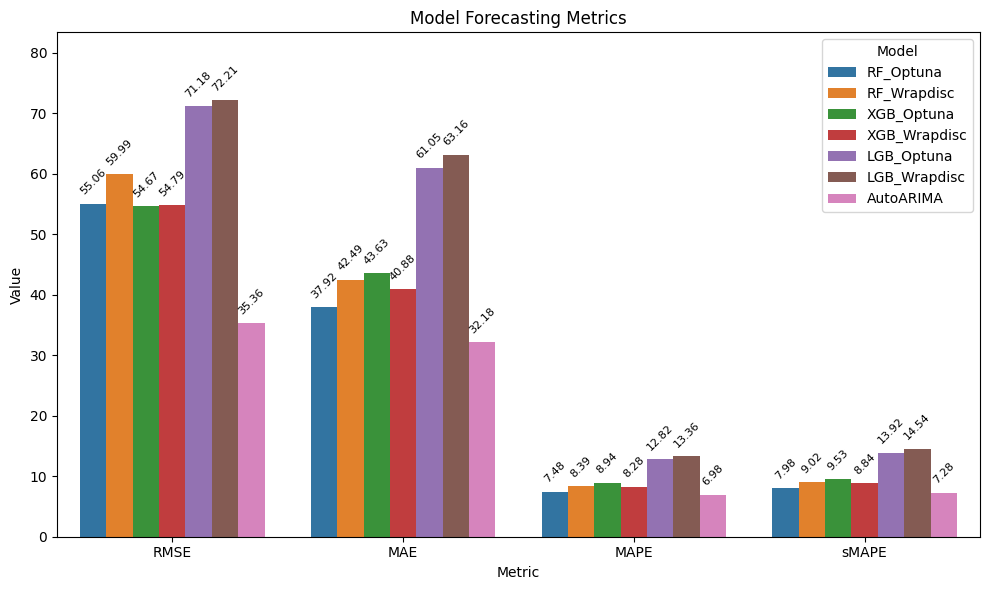

In [56]:
# Plot metrics with metrics on the x-axis
plot_grouped_bar(metrics_df, x_axis="Metric")

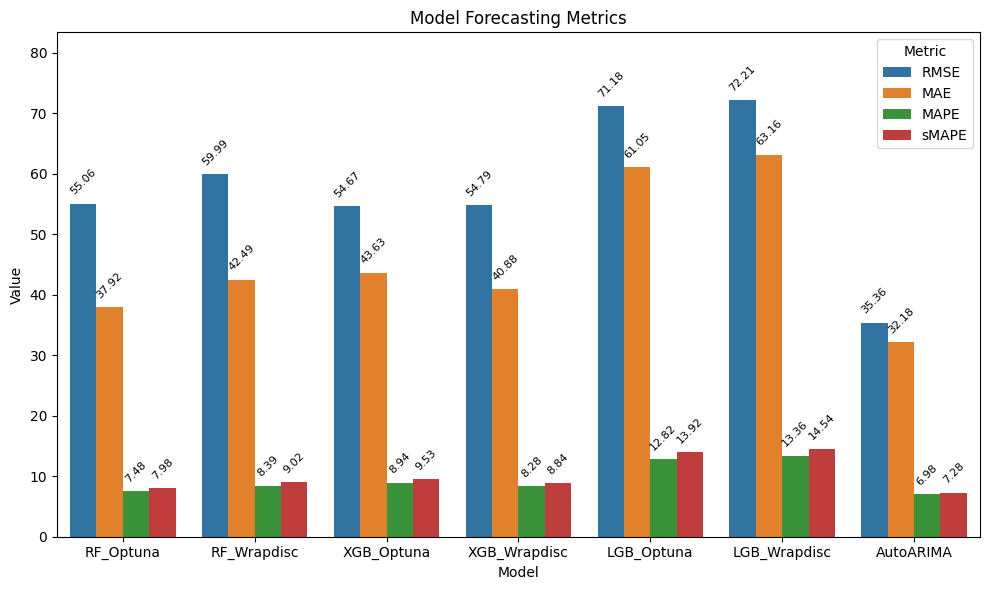

In [57]:
# Plot metrics with models on the x-axis
plot_grouped_bar(metrics_df, x_axis="Model")

# Forecast Plotting

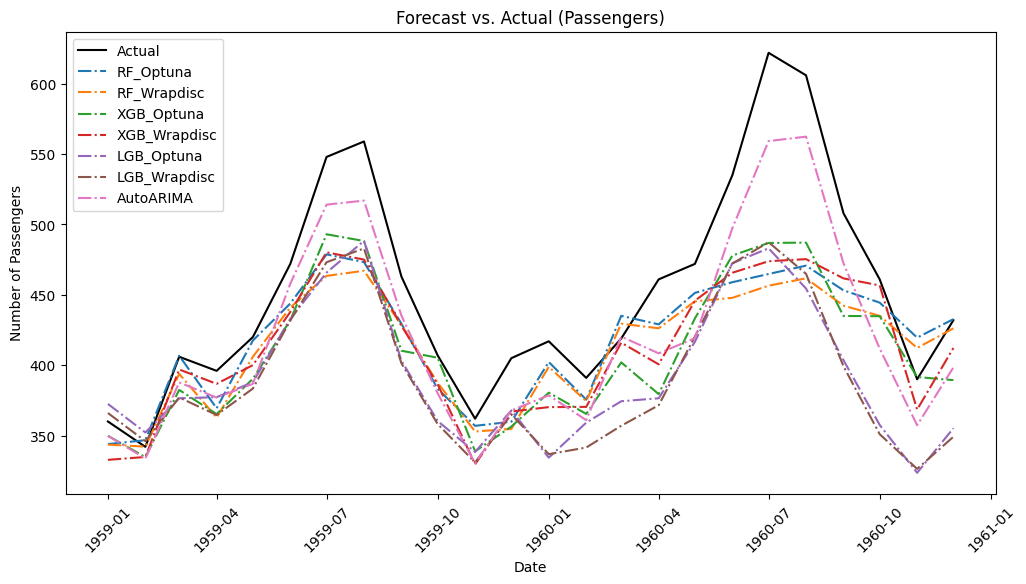

In [58]:
# Plot the forecasts versus the actual test set values
plt.figure(figsize=(12, 6))
plt.plot(test.index, y_test_original, label='Actual', color='black')
plt.plot(test.index, rf_optuna_pred, label='RF_Optuna', linestyle='-.')
plt.plot(test.index, rf_wrapdisc_pred, label='RF_Wrapdisc', linestyle='-.')
plt.plot(test.index, xgb_optuna_pred, label='XGB_Optuna', linestyle='-.')
plt.plot(test.index, xgb_wrapdisc_pred, label='XGB_Wrapdisc', linestyle='-.')
plt.plot(test.index, lgb_optuna_pred, label='LGB_Optuna', linestyle='-.')
plt.plot(test.index, lgb_wrapdisc_pred, label='LGB_Wrapdisc', linestyle='-.')
plt.plot(test.index, arima_pred, label='AutoARIMA', linestyle='-.')
plt.title("Forecast vs. Actual (Passengers)")
plt.xlabel("Date")
plt.ylabel("Number of Passengers")
plt.xticks(rotation=45)
plt.legend()
plt.show()